In [1]:
import os
import shutil
import random
import re
import string

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import numpy as np

print(f'Tensorflow 버전을 확인합니다: {tf.__version__}')

Tensorflow 버전을 확인합니다: 2.15.0


In [3]:
!apt install -qq -y fonts-nanum*

The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up

In [4]:
fonts = fm.findSystemFonts()

nanum_path = None

for font in fonts:

    if font.endswith('NanumGothic.ttf'):

        nanum_path = font

        break

if nanum_path == None:

    print(f'나눔 폰트를 설치해야 합니다!')

    print(f'!apt install -qq -y fonts-nanum*')

else:

    print(f'나눔 폰트 경로: {nanum_path}')

    nanum_prop = fm.FontProperties(fname=nanum_path)


나눔 폰트 경로: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


In [5]:
fm.FontProperties(fname=nanum_path)

In [6]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
untar=True, cache_dir='.',
cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 4s 0us/step


In [7]:
print(f'데이터 압축 디렉터리 내부: {os.listdir(dataset_dir)}')


train_dir = os.path.join(dataset_dir, 'train')
print(f'학습 데이터 디렉터리 내부: {os.listdir(train_dir)}')

데이터 압축 디렉터리 내부: ['test', 'train', 'imdb.vocab', 'imdbEr.txt', 'README']
학습 데이터 디렉터리 내부: ['labeledBow.feat', 'neg', 'unsup', 'urls_unsup.txt', 'urls_neg.txt', 'unsupBow.feat', 'urls_pos.txt', 'pos']


In [10]:
pos_train_dir = os.path.join(train_dir, 'pos')
pos_train_files = os.listdir(pos_train_dir)
neg_train_dir = os.path.join(train_dir, 'neg')
neg_train_files = os.listdir(neg_train_dir)
print('긍정 파일: ', end='')
for _ in range(0, 10):
 print(random.choice(pos_train_files), end=' ')
print()
print('부정 파일: ', end='')
for _ in range(0, 10):
 print(random.choice(neg_train_files), end=' ')
print()

긍정 파일: 11926_10.txt 8673_7.txt 250_7.txt 8126_7.txt 3569_8.txt 5011_10.txt 4103_7.txt 10811_7.txt 10505_10.txt 7420_7.txt 
부정 파일: 1433_4.txt 5911_4.txt 8290_2.txt 3087_2.txt 2828_3.txt 4661_3.txt 4109_1.txt 3564_2.txt 4708_1.txt 11637_4.txt 


In [12]:
sample_file = os.path.join(train_dir, 'pos', '2678_8.txt')
with open(sample_file, 'r') as f:
 print(f.read())

Hey now, I can't claim to have seen all of the films of Jesse (Jesus) Franco, and there sure seem to be a lot of them, but this is one of the better (and weirder) of the lot that I have seen. I'd say most likely he was in his prime back in the late sixties/early seventies and anything lately has been a bit TOO strange for me, and it takes a lot for me to declare that. Anyway, this is like one big bad dream where parts of it seem to come true at various points. This woman is an actress or something, performs in some theater in Berlin where acts of "fake" torture are performed for an appreciative audience (?!) and she seems to have this problem with dreaming. The catch to what's real and what's not in this movie is apparently the real stuff is in sharp focus and the dream stuff isn't. She seems to exist in a state of deja vu. I won't say this makes a whole lot of sense but it is pretty wild and weird and entertaining. Shots of Berlin make it seem like a lonely and creepy place, so that a

In [13]:
print('''학습을 위한 데이터는 이런 구조가 되어야 합니다.
train/
....pos/
........file1.txt
........file2.txt
....neg/
........file1.txt
........file2.txt''')
remove_dir = os.path.join(train_dir, 'unsup')
print(f'불필요한 데이터 파일을 정리합니다. {remove_dir}')
shutil.rmtree(remove_dir)

학습을 위한 데이터는 이런 구조가 되어야 합니다.
train/
....pos/
........file1.txt
........file2.txt
....neg/
........file1.txt
........file2.txt
불필요한 데이터 파일을 정리합니다. ./aclImdb/train/unsup


In [14]:
# 원본: 텐서플로우 Github
## https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/preprocessing/text_dataset.py

import multiprocessing

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.ops import string_ops
from tensorflow.python.util.tf_export import keras_export


def index_directory(directory,
                    labels,
                    formats,
                    class_names=None,
                    shuffle=True,
                    seed=None,
                    follow_links=False):
    inferred_class_names = []
    for subdir in sorted(os.listdir(directory)):
        if os.path.isdir(os.path.join(directory, subdir)):
            inferred_class_names.append(subdir)
    if not class_names:
        class_names = inferred_class_names
    else:
        if set(class_names) != set(inferred_class_names):
            raise ValueError(
                    'The `class_names` passed did not match the '
                    'names of the subdirectories of the target directory. '
                    'Expected: %s, but received: %s' %
                    (inferred_class_names, class_names))
    class_indices = dict(zip(class_names, range(len(class_names))))

    pool = multiprocessing.pool.ThreadPool()
    results = []
    filenames = []
    for dirpath in (os.path.join(directory, subdir) for subdir in class_names):
        results.append(
            pool.apply_async(index_subdirectory,
                             (dirpath, class_indices, follow_links, formats)))
    labels_list = []
    for res in results:
        partial_filenames, partial_labels = res.get()
        labels_list.append(partial_labels)
        filenames += partial_filenames
    if labels != 'inferred':
        if len(labels) != len(filenames):
            raise ValueError('Expected the lengths of `labels` to match the number '
                             'of files in the target directory. len(labels) is %s '
                             'while we found %s files in %s.' % (
                                     len(labels), len(filenames), directory))
    else:
        i = 0
        labels = np.zeros((len(filenames),), dtype='int32')
        for partial_labels in labels_list:
            labels[i:i + len(partial_labels)] = partial_labels
            i += len(partial_labels)

    print('Found %d files belonging to %d classes.' %
          (len(filenames), len(class_names)))
    pool.close()
    pool.join()
    file_paths = [os.path.join(directory, fname) for fname in filenames]

    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(file_paths)
        rng = np.random.RandomState(seed)
        rng.shuffle(labels)
    return file_paths, labels, class_names


def iter_valid_files(directory, follow_links, formats):
    walk = os.walk(directory, followlinks=follow_links)
    for root, _, files in sorted(walk, key=lambda x: x[0]):
        for fname in sorted(files):
            if fname.lower().endswith(formats):
                yield root, fname


def index_subdirectory(directory, class_indices, follow_links, formats):
    dirname = os.path.basename(directory)
    valid_files = iter_valid_files(directory, follow_links, formats)
    labels = []
    filenames = []
    for root, fname in valid_files:
        labels.append(class_indices[dirname])
        absolute_path = os.path.join(root, fname)
        relative_path = os.path.join(
                dirname, os.path.relpath(absolute_path, directory))
        filenames.append(relative_path)
    return filenames, labels


def check_validation_split_arg(validation_split, subset, shuffle, seed):
    if validation_split and not 0 < validation_split < 1:
        raise ValueError(
                '`validation_split` must be between 0 and 1, received: %s' %
                (validation_split,))
    if (validation_split or subset) and not (validation_split and subset):
        raise ValueError(
                'If `subset` is set, `validation_split` must be set, and inversely.')
    if subset not in ('training', 'validation', None):
        raise ValueError('`subset` must be either "training" '
                         'or "validation", received: %s' % (subset,))
    if validation_split and shuffle and seed is None:
        raise ValueError(
                'If using `validation_split` and shuffling the data, you must provide '
                'a `seed` argument, to make sure that there is no overlap between the '
                'training and validation subset.')


def get_training_or_validation_split(samples, labels, validation_split, subset):
    if not validation_split:
        return samples, labels

    num_val_samples = int(validation_split * len(samples))
    if subset == 'training':
        print('Using %d files for training.' % (len(samples) - num_val_samples,))
        samples = samples[:-num_val_samples]
        labels = labels[:-num_val_samples]
    elif subset == 'validation':
        print('Using %d files for validation.' % (num_val_samples,))
        samples = samples[-num_val_samples:]
        labels = labels[-num_val_samples:]
    else:
        raise ValueError('`subset` must be either "training" '
                         'or "validation", received: %s' % (subset,))
    return samples, labels


def labels_to_dataset(labels, label_mode, num_classes):
    label_ds = dataset_ops.Dataset.from_tensor_slices(labels)
    if label_mode == 'binary':
        label_ds = label_ds.map(
                lambda x: array_ops.expand_dims(math_ops.cast(x, 'float32'), axis=-1))
    elif label_mode == 'categorical':
        label_ds = label_ds.map(lambda x: array_ops.one_hot(x, num_classes))
    return label_ds


def paths_and_labels_to_dataset(file_paths,
                                labels,
                                label_mode,
                                num_classes,
                                max_length):
    path_ds = dataset_ops.Dataset.from_tensor_slices(file_paths)
    string_ds = path_ds.map(
        lambda x: path_to_string_content(x, max_length))
    if label_mode:
        label_ds = labels_to_dataset(labels, label_mode, num_classes)
        string_ds = dataset_ops.Dataset.zip((string_ds, label_ds))
    return string_ds


def path_to_string_content(path, max_length):
    txt = io_ops.read_file(path)
    if max_length is not None:
        txt = string_ops.substr(txt, 0, max_length)
    return txt


def text_dataset_from_directory(directory,
                                labels='inferred',
                                label_mode='int',
                                class_names=None,
                                batch_size=32,
                                max_length=None,
                                shuffle=True,
                                seed=None,
                                validation_split=None,
                                subset=None,
                                follow_links=False):
    if labels != 'inferred':
        if not isinstance(labels, (list, tuple)):
            raise ValueError(
                    '`labels` argument should be a list/tuple of integer labels, of '
                    'the same size as the number of text files in the target '
                    'directory. If you wish to infer the labels from the subdirectory '
                    'names in the target directory, pass `labels="inferred"`. '
                    'If you wish to get a dataset that only contains text samples '
                    '(no labels), pass `labels=None`.')
        if class_names:
            raise ValueError('You can only pass `class_names` if the labels are '
                             'inferred from the subdirectory names in the target '
                             'directory (`labels="inferred"`).')
    if label_mode not in {'int', 'categorical', 'binary', None}:
        raise ValueError(
                '`label_mode` argument must be one of "int", "categorical", "binary", '
                'or None. Received: %s' % (label_mode,))
    if seed is None:
        seed = np.random.randint(1e6)
    check_validation_split_arg(
        validation_split, subset, shuffle, seed)

    file_paths, labels, class_names = index_directory(
            directory,
            labels,
            formats=('.txt',),
            class_names=class_names,
            shuffle=shuffle,
            seed=seed,
            follow_links=follow_links)

    if label_mode == 'binary' and len(class_names) != 2:
        raise ValueError(
                'When passing `label_mode="binary", there must exactly 2 classes. '
                'Found the following classes: %s' % (class_names,))

    file_paths, labels = get_training_or_validation_split(
        file_paths, labels, validation_split, subset)

    dataset = paths_and_labels_to_dataset(
        file_paths=file_paths,
        labels=labels,
        label_mode=label_mode,
        num_classes=len(class_names),
        max_length=max_length)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset.class_names = class_names
    return dataset


In [15]:
batch_size = 32
validation_split = 0.2
seed = 20200721

print('학습 데이터 세트를 불러옵니다.')
raw_train_ds = text_dataset_from_directory(
train_dir,
batch_size=batch_size,
validation_split=validation_split,
subset='training',
seed=seed)

학습 데이터 세트를 불러옵니다.
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [21]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
print("Label", label_batch.numpy()[i])


print('레이블 번호 - 이름 확인!')
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


print('검증 데이터 세트를 불러옵니다.')
raw_val_ds = text_dataset_from_directory(
train_dir,
batch_size=batch_size,
validation_split=validation_split,
subset='validation',
seed=seed)

Review b"This film was a yawn from titles to credits, it's boring to the point of tedium and the acting is wooden and stilted! Admittedly this was director Richard Jobson directing debut, but who on earth green-lit a script as poorly developed as this one? Looks like another money down the drain government project (Scottish Screen are credited surprise, surprise). I nearly fell asleep three times and my review will unfortunately have to be more restrained than this one. Please, please mister Jobson what ever you've been doing prior to directing this sedative of a film, go back to it!"
Review b'I have given this show (I have only watched seven episodes) four stars because most of her jokes/set-ups appear to fail. Some are not funny outright, but some are amusing -- in a 12 year old boy kind of way. She reminds me of that New York painter who throws paint upon a canvas, calls it art and sells it for a lot of money. Silverman throws out what she\'s got, including the kitchen sink, while s

In [27]:
import tensorflow as tf
import re
import string

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')
max_features = 1000
sequence_length = 50

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
standardize=custom_standardization,
max_tokens=max_features,
output_mode='int',
output_sequence_length=sequence_length)

print('테스트 데이터와 레이블을 분리합니다.')
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

테스트 데이터와 레이블을 분리합니다.


In [28]:
print('테스트 데이터와 레이블을 분리합니다.')
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


print('학습 완료 후 사용할 테스트 세트를 불러옵니다.')
test_dir = os.path.join(dataset_dir, 'test')
raw_test_ds = text_dataset_from_directory(
test_dir,
batch_size=batch_size)

테스트 데이터와 레이블을 분리합니다.
학습 완료 후 사용할 테스트 세트를 불러옵니다.
Found 25000 files belonging to 2 classes.


In [31]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

print('테스트 데이터를 확인합니다.')
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(tf.expand_dims(first_review, -1), first_label))

테스트 데이터를 확인합니다.
Review tf.Tensor(b'As shallow as it may sound, I actually delayed my viewing of "The Barbarians" several times just because the VHS cover (as well as the picture image displayed here on the website) looks so incredibly gay! By now I wish I had watched it earlier because the movie isn\'t so much gay\xc2\x85. just trashy, cheesy, campy and enormously fun! It\'s almost unbelievable that Ruggero Deodato, director of "Cannibal Holocaust" of all people, was the man responsible for this comical cash-in on the contemporary popular Sword & Sandal fantasy flicks, particularly Schwarzenegger\'s Conan movies. The film opens with a terrific \'once-upon-a-time\' type of off-screen narrator, introducing us to the Ragneks. Their founder once traded an entire mountain of pure gold for just one magically powerful ruby that would allow them to travel in freedom and access every country as entertainers. In other words, the Ragneks are a bunch of traveling circus freaks! Their happiness abr

In [39]:
print('각 특징 벡터의 원소 값을 확인할 수 있습니다.')
voc_size = len(vectorize_layer.get_vocabulary())
print(f'Vocabulary size: {voc_size}')
base = 0
cnt = 10
if voc_size - cnt < base:
  print(f'{voc_size-cnt} 보다는 작은 수를 입력해야 합니다.')
else:
  for i in range(base, base+cnt):
    print(f'{i+2:4d} ---> {vectorize_layer.get_vocabulary()[i]}')

각 특징 벡터의 원소 값을 확인할 수 있습니다.
Vocabulary size: 1000
   2 ---> 
   3 ---> [UNK]
   4 ---> the
   5 ---> and
   6 ---> a
   7 ---> of
   8 ---> to
   9 ---> is
  10 ---> in
  11 ---> it


In [40]:
print('학습, 검증, 테스트 데이터를 모두 벡터화 합니다.')
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


AUTOTUNE = tf.data.experimental.AUTOTUNE
print('데이터 입력부를 최적화합니다.')
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

학습, 검증, 테스트 데이터를 모두 벡터화 합니다.
데이터 입력부를 최적화합니다.


In [48]:
import tensorflow as tf

embedding_dim = 4
max_features = 10000  # Example value, you should set this to your actual value

print('모델을 정의합니다.')
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, embedding_dim, mask_zero=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.summary()

print('모델을 준비합니다.')
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)]
)

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

모델을 정의합니다.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           40004     
                                                                 
 dropout (Dropout)           (None, None, 4)           0         
                                                                 
 global_average_pooling1d (  (None, 4)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 40009 (156.29 KB)
Trainable params: 40009 (156.29 KB)
Non-trainable params: 0 (0.00 Byte)
_______

In [49]:
print('모델 성능을 테스트합니다.')
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

모델 성능을 테스트합니다.
782/782 [==============================] - 9s 11ms/step - loss: 0.5137 - binary_accuracy: 0.7406
Loss:  0.5137481093406677
Accuracy:  0.740559995174408


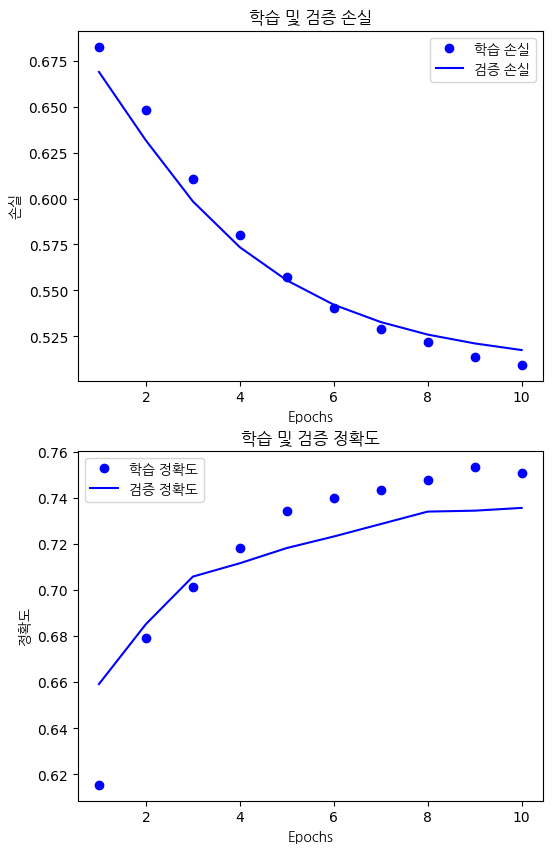

In [50]:
history_dict = history.history

acc = history_dict['binary_accuracy']

val_acc = history_dict['val_binary_accuracy']

loss = history_dict['loss']

val_loss = history_dict['val_loss']


epochs = range(1, len(acc) + 1)


fig1 = plt.figure(figsize=(6, 10))

ax = fig1.add_subplot(2, 1, 1)

ax.plot(epochs, loss, 'bo', label='학습 손실')

ax.plot(epochs, val_loss, 'b', label='검증 손실')

ax.set_title('학습 및 검증 손실', fontproperties=nanum_prop, fontsize=12)

ax.set_xlabel('Epochs', fontproperties=nanum_prop, fontsize=10)

ax.set_ylabel('손실', fontproperties=nanum_prop, fontsize=10)

ax.legend(prop=nanum_prop)


ax = fig1.add_subplot(2, 1, 2)

ax.plot(epochs, acc, 'bo', label='학습 정확도')

ax.plot(epochs, val_acc, 'b', label='검증 정확도')

ax.set_title('학습 및 검증 정확도', fontproperties=nanum_prop, fontsize=12)

ax.set_xlabel('Epochs', fontproperties=nanum_prop, fontsize=10)

ax.set_ylabel('정확도', fontproperties=nanum_prop, fontsize=10)

ax.legend(prop=nanum_prop)